In [12]:
# Necessary to run 2 times
!sudo apt-get install build-essential swig
!pip install auto-sklearn
!pip install scikit-learn==0.24.2
!pip install imbalanced-learn==0.8.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
!pip install numpy==1.23.5
from autosklearn import classification
from imblearn import over_sampling
from keras import callbacks
from keras import models
from keras import layers
from keras import optimizers
from matplotlib import pyplot
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm
from sklearn import utils
from random import seed

from autosklearn.metrics import (accuracy,
                                 f1,
                                 roc_auc,
                                 precision,
                                 average_precision,
                                 recall,
                                 log_loss)

orig_dataset = pd.read_csv("cqi_dataset.csv")
orig_dataset.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ID  Species  Variety    Country        Region  Altitude     Processing  \
0   0  Arabica      NaN   Ethiopia  Guji, Oromia    2075.0   Washed / Wet   
1   1  Arabica      NaN   Ethiopia  Guji, Oromia    2075.0   Washed / Wet   
2   2  Arabica  Bourbon  Guatemala           NaN    1700.0            NaN   
3   3  Arabica      NaN   Ethiopia        Oromia    2000.0  Natural / Dry   
4   4  Arabica      NaN   Ethiopia  Guji, Oromia    2075.0   Washed / Wet   

   Aroma  Flavor  Aftertaste  ...  Uniformity  Clean.Cup  Sweetness  \
0   8.67    8.83        8.67  ...        10.0       10.0       10.0   
1   8.75    8.67        8.50  ...        10.0       10.0       10.0   
2   8.42    8.50        8.42  ...        10.0       10.0       10.0   
3   8.17    8.58        8.42  ...        10.0       10.0       10.0   
4   8.25    8.50        8.25  ...        10.0       10.0       10.0   

   Cupper.Points  Total.Cup.Points  Moisture  Category.One.Defects  Quakers  \
0           8.75             90.58      0.12                     0        0   
1           8.58             89.92      0.12                     0        0   
2           9.25             89.75      0.00                     0        0   
3           8.67             89.00      0.11                     0        0   
4           8.58             88.83      0.12                     0        0   

   Color  Category.Two.Defects  
0  Green                     0  
1  Green                     1  
2    NaN                     0  
3  Green                     2  
4  Green                     2  

[5 rows x 23 columns]

Prepare train test splits

In [3]:
# Remove entries without common country
filtered_dataset = orig_dataset.dropna(subset=["Country"])
filtered_dataset = filtered_dataset.groupby("Country").filter(lambda x: len(x) >= 100)
train, test = model_selection.train_test_split(filtered_dataset, test_size=0.3, random_state=42)

print("Train set")
train_countries = train.Country.value_counts()
print(train_countries)

print("Test set")
test_countries = test.Country.value_counts()
print(test_countries)

Train set
Mexico       159
Guatemala    139
Colombia     135
Brazil       100
Taiwan        81
Name: Country, dtype: int64
Test set
Mexico       77
Colombia     62
Guatemala    51
Taiwan       40
Brazil       34
Name: Country, dtype: int64


**Baseline prediction**

In [7]:
train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

In [10]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(train_X, train_y)

DummyClassifier(random_state=42, strategy='stratified')

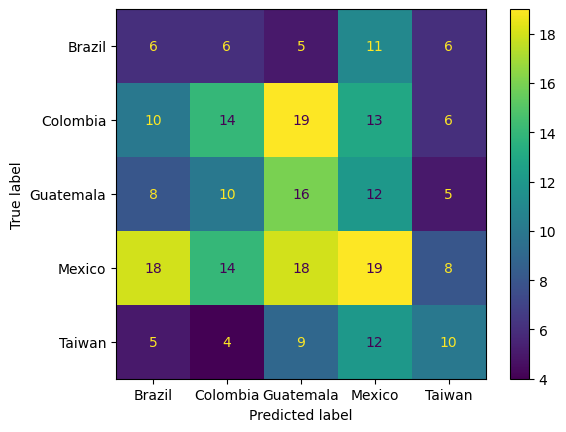

Accuracy: 0.24621212121212122
Weighted F1 score: 0.24861922274447953


In [11]:
pred_y = dummy.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Logistic regression for prediction of country from cupping score**

In [12]:
train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

In [13]:
model = linear_model.LogisticRegression(solver="newton-cg", random_state=42)
model.fit(train_X, train_y)

LogisticRegression(random_state=42, solver='newton-cg')

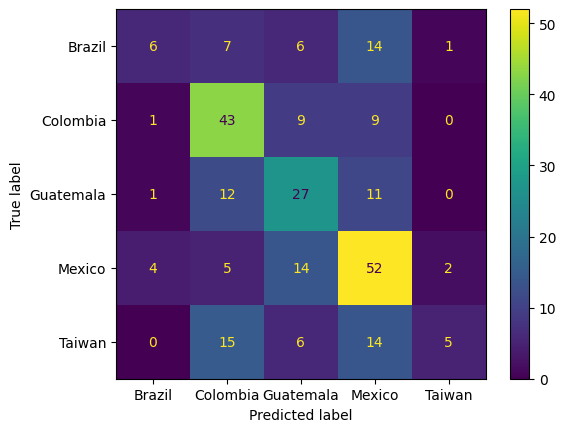

Accuracy: 0.5037878787878788
Weighted F1 score: 0.4691109681724961


In [14]:
pred_y = model.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Binary ensemble SVM for prediction of country from cupping score**

In [15]:
def get_prediction_from_ensemble(test_X, test_y, index, ensemble):
    result_name = ""
    max_prob = 0
    # Pick country with largest probability
    for name, model in ensemble.items():
        if (model.predict_proba([test_X.iloc[index]])[0][1] > max_prob):
            max_prob = model.predict_proba([test_X.iloc[index]])[0][1]
            result_name = name

    return result_name

Create oversampled training datasets

In [16]:
oversampled_datasets = {}
# For each country, prepare balanced dataset by oversampling of target category
for country_name, country_count in train_countries.items():
    positives_dataset = train[train.Country == country_name].copy()
    positives_dataset["is_positive"] = 1
    negatives_dataset = train[train.Country != country_name].copy()
    negatives_dataset["is_positive"] = 0

    # Oversample target country
    positives_over = positives_dataset.sample(len(train.index - country_count), replace=True, random_state=42)

    # Join datasets
    oversampled_dataset = pd.concat([positives_over, negatives_dataset])
    oversampled_datasets[country_name] = oversampled_dataset
    
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

Train each binary classifier

In [17]:
ensemble = {}
for name, dataset in oversampled_datasets.items():

    train_X = dataset[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
    train_y = np.array(dataset.is_positive)
    
    model = svm.SVC(probability=True, C=5, gamma="auto", random_state=42)
    model.fit(train_X.values, train_y)
    ensemble[name] = model

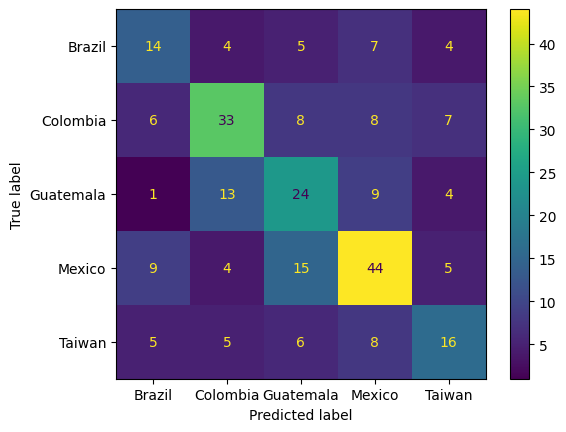

Accuracy: 0.4962121212121212
Weighted F1 score: 0.4969836584329233


In [18]:
pred_y = []
for i in range(len(test_y)):
    pred_y.append(get_prediction_from_ensemble(test_X, test_y, i, ensemble))

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Auto SKLearn for prediction of country from cupping score**

In [19]:
seed(0)

train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

automl = classification.AutoSklearnClassifier(time_left_for_this_task=300,
                                              resampling_strategy="cv",
                                              memory_limit = 102400)
automl.fit(train_X, train_y)
df_cv_results = pd.DataFrame(automl.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results

mean_test_score  rank_test_scores  mean_fit_time  \
11         0.517915                 1      14.145244   
7          0.490228                 2      11.459963   
0          0.483713                 3      10.057903   
17         0.469055                 4       5.606387   
16         0.464169                 5      12.601221   
2          0.452769                 6      10.358744   
18         0.452769                 6       3.951196   
8          0.452769                 6       4.494767   
12         0.439739                 9      10.232701   
13         0.436482                10      10.203777   
15         0.429967                11       4.675970   
9          0.412052                12       9.790543   
10         0.397394                13      10.337276   
14         0.387622                14       4.247030   
5          0.258958                15      21.349026   
1          0.000000                16      30.022604   
6          0.000000                16      30.018397   
4          0.000000                16      30.018940   
3          0.000000                16      30.021411   
19         0.000000                16      13.023094   

                                               params   status  budgets  \
11  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
7   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
0   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
17  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
16  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
2   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
18  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
8   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
12  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
13  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
15  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
9   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
10  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
14  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
5   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
1   {'balancing:strategy': 'none', 'classifier:__c...  Timeout      0.0   
6   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
4   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
3   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
19  {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   

   param_balancing:strategy param_classifier:__choice__  \
11                     none               random_forest   
7                 weighting               random_forest   
0                      none               random_forest   
17                weighting           gradient_boosting   
16                     none                         mlp   
2                      none               random_forest   
18                weighting                  libsvm_svc   
8                 weighting                  libsvm_svc   
12                weighting               random_forest   
13                     none               random_forest   
15                weighting                         lda   
9                      none               random_forest   
10                     none                         mlp   
14                     none           gradient_boosting   
5                 weighting                         sgd   
1                      none               random_forest   
6                 weighting                         mlp   
4                 weighting           gradient_boosting   
3                 weighting           gradient_boosting   
19                weighting                         lda   

   param_da

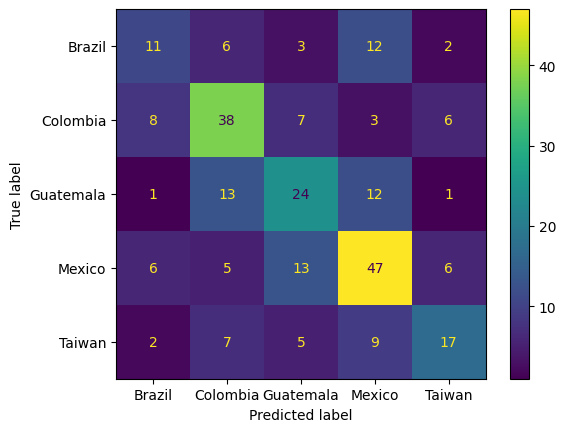

Accuracy: 0.5189393939393939
Weighted F1 score: 0.5148763672652964


In [20]:
pred_y = automl.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Auto SKLearn for prediction of country from cupping score (SMOTE resampling)**

In [21]:
seed(0)

train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

sm = over_sampling.SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X, train_y = utils.shuffle(train_X, train_y)

automl_smote = classification.AutoSklearnClassifier(time_left_for_this_task=300,
                                                    resampling_strategy="cv",
                                                    memory_limit = 102400)
automl_smote.fit(train_X, train_y)
df_cv_results = pd.DataFrame(automl.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results

mean_test_score  rank_test_scores  mean_fit_time  \
11         0.517915                 1      14.145244   
7          0.490228                 2      11.459963   
0          0.483713                 3      10.057903   
17         0.469055                 4       5.606387   
16         0.464169                 5      12.601221   
2          0.452769                 6      10.358744   
18         0.452769                 6       3.951196   
8          0.452769                 6       4.494767   
12         0.439739                 9      10.232701   
13         0.436482                10      10.203777   
15         0.429967                11       4.675970   
9          0.412052                12       9.790543   
10         0.397394                13      10.337276   
14         0.387622                14       4.247030   
5          0.258958                15      21.349026   
1          0.000000                16      30.022604   
6          0.000000                16      30.018397   
4          0.000000                16      30.018940   
3          0.000000                16      30.021411   
19         0.000000                16      13.023094   

                                               params   status  budgets  \
11  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
7   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
0   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
17  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
16  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
2   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
18  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
8   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
12  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
13  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
15  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
9   {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
10  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
14  {'balancing:strategy': 'none', 'classifier:__c...  Success      0.0   
5   {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
1   {'balancing:strategy': 'none', 'classifier:__c...  Timeout      0.0   
6   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
4   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
3   {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   
19  {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   

   param_balancing:strategy param_classifier:__choice__  \
11                     none               random_forest   
7                 weighting               random_forest   
0                      none               random_forest   
17                weighting           gradient_boosting   
16                     none                         mlp   
2                      none               random_forest   
18                weighting                  libsvm_svc   
8                 weighting                  libsvm_svc   
12                weighting               random_forest   
13                     none               random_forest   
15                weighting                         lda   
9                      none               random_forest   
10                     none                         mlp   
14                     none           gradient_boosting   
5                 weighting                         sgd   
1                      none               random_forest   
6                 weighting                         mlp   
4                 weighting           gradient_boosting   
3                 weighting           gradient_boosting   
19                weighting                         lda   

   param_da

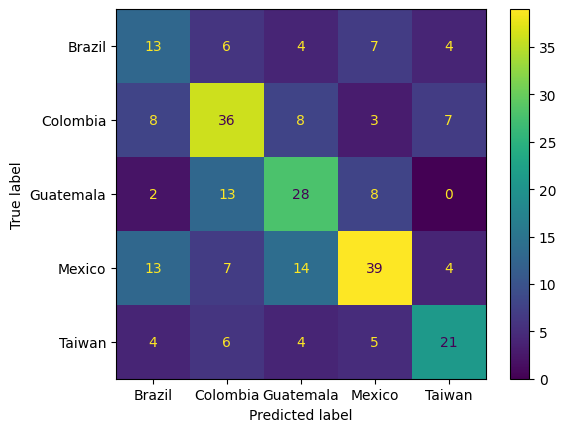

Accuracy: 0.5189393939393939
Weighted F1 score: 0.521970221962927


In [22]:
pred_y = automl_smote.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Neural network for prediction of country from cupping score (SMOTE resampling)**

Výstupní stream byl oříznut na posledních 5000 řádků.
Epoch 502/3000
19/19 [==============================] - 0s 7ms/step - loss: 1.5022 - accuracy: 0.3003 - val_loss: 1.5155 - val_accuracy: 0.3116
Epoch 503/3000
19/19 [==============================] - 0s 5ms/step - loss: 1.5347 - accuracy: 0.2651 - val_loss: 1.5182 - val_accuracy: 0.2462
Epoch 504/3000
19/19 [==============================] - 0s 4ms/step - loss: 1.4998 - accuracy: 0.2718 - val_loss: 1.6142 - val_accuracy: 0.2161
Epoch 505/3000
19/19 [==============================] - 0s 6ms/step - loss: 1.5227 - accuracy: 0.2802 - val_loss: 1.5303 - val_accuracy: 0.2915
Epoch 506/3000
19/19 [==============================] - 0s 4ms/step - loss: 1.4918 - accuracy: 0.2701 - val_loss: 1.7965 - val_accuracy: 0.2111
Epoch 507/3000
19/19 [==============================] - 0s 4ms/step - loss: 1.5589 - accuracy: 0.2483 - val_loss: 1.5261 - val_accuracy: 0.2613
Epoch 508/3000
19/19 [==============================] - 0s 4ms/step - loss: 1.5207

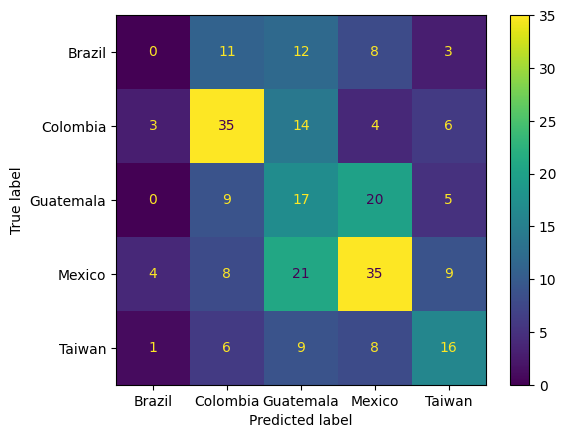

Accuracy: 0.39015151515151514
Weighted F1 score: 0.3741541663691949


In [23]:
seed(0)

train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

sm = over_sampling.SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X, train_y = utils.shuffle(train_X, train_y)

lb = preprocessing.LabelBinarizer()
train_y = lb.fit_transform(train_y)
train_X, val_X, train_y, val_y = model_selection.train_test_split(train_X, train_y, random_state=42)

model = models.Sequential()
model.add(layers.Dense(10, input_shape=(10,), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.SGD(),
  metrics=['accuracy']
)

print(model.summary())
model.fit(train_X, train_y,
          epochs=3000,
          verbose=1,
          validation_data=(val_X, val_y))

pred_y = model.predict(test_X)
pred_y = lb.inverse_transform(pred_y)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Random forest classifier (best by auto-sklearn choice)**

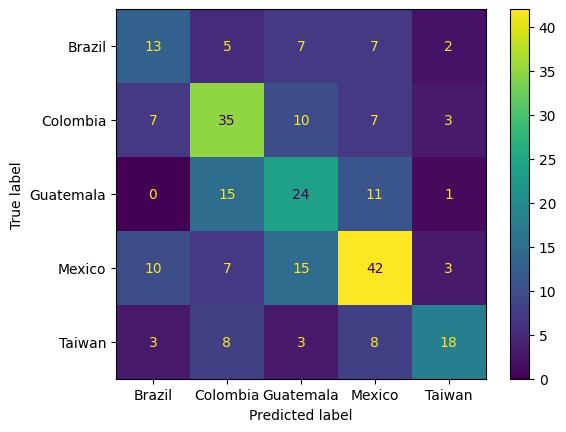

Accuracy: 0.5
Weighted F1 score: 0.5014111063502267


In [25]:
from sklearn.ensemble import RandomForestClassifier

train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(train_X, train_y)

pred_y = forest_model.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))

**Gradient boosting classifier (currently the best)**

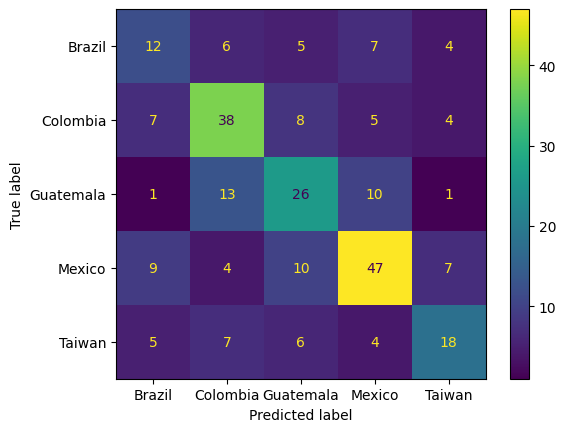

Accuracy: 0.5340909090909091
Weighted F1 score: 0.534006873346496


In [26]:
from sklearn.ensemble import GradientBoostingClassifier

train_X = train[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
train_y = np.array(train.Country)
test_X = test[["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]]
test_y = np.array(test.Country)

sm = over_sampling.SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X, train_y = utils.shuffle(train_X, train_y, random_state=0)

boost_model = GradientBoostingClassifier(random_state=42)
boost_model.fit(train_X, train_y)

pred_y = boost_model.predict(test_X)

cm = metrics.confusion_matrix(test_y, pred_y, labels=np.unique(test_y))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_y))

disp.plot()
pyplot.show()

print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Weighted F1 score:", metrics.f1_score(test_y, pred_y, average="weighted"))